## Исследование надёжности заёмщиков

Задача -  проанализировать влияние семейного положения и количества детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

## Описание данных

- *children* - количество детей в семье
- *days_employed* - общий трудовой стаж в днях
- *dob_years* - возраст клиента в годах
- *education* - уровень образования клиента
- *education_id* - идентификатор уровня образования
- *family_status* — семейное положение
- *family_status_id* — идентификатор семейного положения
- *gender* — пол клиента
- *income_type* — тип занятости
- *debt* — имел ли задолженность по возврату кредитов
- *total_income* — ежемесячный доход
- *purpose* — цель получения кредита

# Содержание

1. [Чтение данных](#step1)
2. [Предобработка данных](#step2) 
    * Обработака пропусков  
    * Замена типа данных  
    * Обработка дубликатов  
    * Лемматизация  
    * Категоризация данных  
3. [Ответы на вопросы исследования](#step3)
4. [Общий вывод](#step4)




<a id='step1'></a>

### 1. Чтение данных 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('datasets/data.csv')

In [3]:
#посмотрим, как выглядят данные
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Сразу видно, что что-то не так с переменной days_employed: для некоторых строк она принимает отрицательные значения. Кроме того, в столбце education явно есть дубликаты из-за регистра.

In [4]:
#избавимся от отрицательных значений
df.loc[df['days_employed']<0, 'days_employed'] = abs(
    df.loc[df['days_employed']<0, 'days_employed'])

In [5]:
#переведем значения столбца education в нижний регистр
df['education'] = df['education'].str.lower()

In [6]:
#общая информация о данных:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Вывод

В файле имеются данные о 21525 клиентах. Очевидно, пропущенные значения есть в столбцах days_employed и total_income. Обе переменные непрерывные, их значения относятся к типу float64.
Что касается дохода, возможно, некоторые клиенты не захотели давать такую информацию. В случае с трудовым стажем, возможно, кто-то из клиентов просто никогда не работал.

<a id='step2'></a>
[К содержанию](#Содержание)

### 2. Предобработка данных

### Обработка пропусков

In [7]:
#еще раз проверим, в каких столбцах есть пропущенные значения
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [8]:
#посмотрим на таких клиентов подробнее
df[df['days_employed'].isna()].income_type.unique()

array(['пенсионер', 'госслужащий', 'компаньон', 'сотрудник',
       'предприниматель'], dtype=object)

Поскольку среди тех клиентов, у кого пропущены данные о трудовом стаже, нет ни домохозяек, ни безработных, скорее всего, эти пропуски носят случайный характер.

In [9]:
df[df['total_income'].isna()].income_type.unique()

array(['пенсионер', 'госслужащий', 'компаньон', 'сотрудник',
       'предприниматель'], dtype=object)

Среди тех, у кого пропущена информация о доходе, также есть представители разных типов занятости. Причем, значения совпадают. Возможно, это одни и те же люди.

In [10]:
missed = df[df['days_employed'].isna() & df['total_income'].isna()]
missed.shape[0]

2174

Так и есть, пропуски симметричны. Возможно, информация об этой части клиентов была добавлена из другого источника, где не было данных о доходе и стаже.

In [11]:
print('Строки с пропущенными значениями составляют {:.2%} от всей выборки'.format(
    missed.shape[0]/df.shape[0]))

Строки с пропущенными значениями составляют 10.10% от всей выборки


Удаление строк привело бы к значительной потере информации. Заменим пропуски типичным значением.

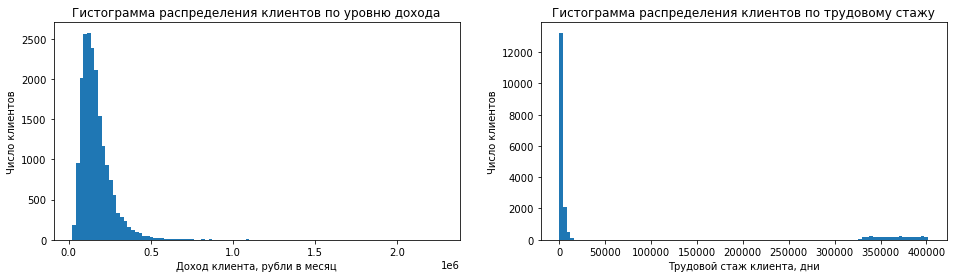

In [12]:
#посмотрим на распределение данных в столбцах с пропусками
fig = plt.figure(figsize=(16,4))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.set_title('Гистограмма распределения клиентов по уровню дохода')
ax2.set_title('Гистограмма распределения клиентов по трудовому стажу')
ax1.set_xlabel('Доход клиента, рубли в месяц')
ax2.set_xlabel('Трудовой стаж клиента, дни')
ax1.set_ylabel('Число клиентов')
ax2.set_ylabel('Число клиентов')
ax1.hist(df[~df['total_income'].isna()]['total_income'], bins=100)
ax2.hist(df[~df['days_employed'].isna()]['days_employed'], bins=100);

Распределения сильно скошенные, так что заменять будем медианными значениями. К тому же, на гистограмме видно, что данные о трудовом стаже имеют аномалии: значения свыше 300000 дней не соответствуют действительности. 

In [13]:
#смотрим, сколько таких значений
df_artf = df[df['days_employed']>300000]
print(f'{df_artf.shape[0]/df.shape[0]:.2%}', sep='')

16.00%


16% -  достаточно много. Возможно, это значения стажа в часах. 

In [14]:
#для грубого расчета примем 8 часовой рабочий день и 247 рабочих дней в году
print((300000/8)/247)
print((400000/8)/247)

151.82186234817814
202.42914979757086


Все равно получается много. Возможно, есть какие-то особенности  рассчетом трудового стажа (год за два и прочее), но поскольку в проекте требуется исследовать влияние семейного положения и количества детей, а не трудового стажа, оставим как получилось.

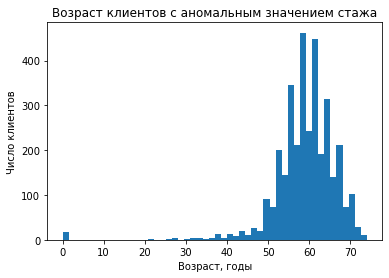

In [15]:
fig = plt.figure(figsize=(6,4))
plt.hist(df_artf['dob_years'], bins=50)
plt.title('Возраст клиентов с аномальным значением стажа')
plt.xlabel('Возраст, годы')
plt.ylabel('Число клиентов');

В основном, люди старшего возраста, хотя как-то попали и клиенты моложе сорока лет. Также, обнаружились аномалии - вряд ли клиентами банка могут быть дети младше 10 лет.

In [16]:
#заменим аномальные значения стажа переведенными в дни из часов значениями
df.loc[df['days_employed']>300000, 'days_employed'] = df.loc[df[
    'days_employed']>300000, 'days_employed']/8

In [17]:
#заменим аномальные значения возраста на среднее
df.loc[df['dob_years']<10, 'dob_years'] = df['dob_years'].mean()

Пропущенные значения дохода и стажа заполним медианными значениями в зависимости от типа занятости.

In [18]:
#группируем данные по типу занятости и находим медианы
df_grouped_by_income_type = df.groupby('income_type')[[
    'days_employed', 'total_income']].median()
df_grouped_by_income_type

,days_employed,total_income
income_type,,
безработный,45801.706593,131339.751676
в декрете,3296.759962,53829.130729
госслужащий,2689.368353,150447.935283
компаньон,1547.382223,172357.950966
пенсионер,45651.663283,118514.486412
предприниматель,520.848083,499163.144947
сотрудник,1574.202821,142594.396847
студент,578.751554,98201.625314


In [19]:
#заполняем пропуски в группах:
try:
    for itype in list(df_grouped_by_income_type.index):
        df.loc[df['income_type'] == itype, 'days_employed'] = df.loc[
            df['income_type'] == itype, 'days_employed'].fillna(
            df_grouped_by_income_type['days_employed'][itype])
        df.loc[df['income_type'] == itype, 'total_income'] = df.loc[
            df['income_type'] == itype, 'total_income'].fillna(
            df_grouped_by_income_type['total_income'][itype])
except NameError as msg:
    print(msg)

In [20]:
#убедимся, что пропуски заполнены
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

In [21]:
#посмотрим на данные после всех преобразований
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000,2.152500e+04
mean,0.538908,10052.618425,43.496522,0.817236,0.972544,0.080883,1.652253e+05
std,1.381587,16777.075914,12.218174,0.548138,1.420324,0.272661,9.804367e+04
min,-1.000000,24.141633,19.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,1025.549623,34.000000,1.000000,0.000000,0.000000,1.077982e+05
50%,0.000000,1993.522017,43.000000,1.000000,0.000000,0.000000,1.425944e+05
75%,1.000000,5347.024506,53.000000,1.000000,1.000000,0.000000,1.955499e+05
max,20.000000,50219.425059,75.000000,4.000000,4.000000,1.000000,2.265604e+06


-1 ребёнок - это странно. Заменим такие значения на 0. Вероятно, -1 значит 'не применимо', то есть у человека нет детей.

In [22]:
df.loc[df['children']==-1, 'children'] = 0

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  float64
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 2.0+ MB


### Вывод

В данных были найдены пропущенные значения в столбцах days_employed и total_income. Пропуски заменены медианными значениями по типам занятости.
Обнаружены аномалии в столбце days_employed (отрицательные значения переведены в положительные, аномально большие значения грубо переведены в часы в предположении, что проблема в единицах измерения), в столбце dob_years (аномальные значения заменены средними) и в солбце children (значения -1 заменены нулями).

### Замена типа данных

Возраст не имеет смысла хранить в вещественном типе. Стаж, измеряемый в днях и доход, измеряемый в рублях логично перевести в целочисленный тип. Поскольку значения нужно перевести из одного числового типа в другой, воспользуемся методом astype().

In [24]:
df['days_employed'] = df['days_employed'].astype('int')
df['dob_years'] = df['dob_years'].astype('int')
df['total_income'] = df['total_income'].astype('int')

In [25]:
info = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int64 
 2   dob_years         21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int64 
 11  purpose           21525 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


### Вывод

Вещественный тип данных заменен на целочисленный методом astype().

### Обработка дубликатов

In [26]:
#посмотрим, есть ли в данных грубые дубликаты
df.duplicated().sum()

71

In [27]:
#удаляем дубликаты:
df = df.drop_duplicates().reset_index(drop=True)

Посмотрим, нет ли дубликатов взначениях категориальных переменных.

In [28]:
df.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

In [29]:
df.education.unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [30]:
df.family_status.unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [31]:
df['family_status'] = df['family_status'].str.lower()

In [32]:
df.gender.unique()

array(['F', 'M', 'XNA'], dtype=object)

In [33]:
#посмотрим на строки с непонятным значением пола
df[df['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10684,0,2358,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905,покупка недвижимости


In [34]:
df.gender.value_counts()

F      14174
M       7279
XNA        1
Name: gender, dtype: int64

Это всего одна строка. По остальным характеристикам информацию восстановить не удается. Заменим XNA на наиболее частое значение, то есть F.

In [35]:
df.loc[df['gender'] == 'XNA', 'gender'] = 'F'

In [36]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

### Вывод

Удален 71 грубый дубликат. Их появление, возможно, связано с объединением данных из разных источников. Дубликатов, связанных с неверным написанием или регистром, не обнаружено.
Количество категорий в целях кредита будет уменьшено в следующем шаге.


### Лемматизация

Цели кредита, судя по уникальным значениям, можно разделить на категории: недвижимость, автомобиль, образование, свадьба

In [37]:
from pymystem3 import Mystem

In [38]:
m = Mystem()

In [39]:
def purpose_cats(purpose):
    lemmatized = m.lemmatize(purpose)
    if ('недвижимость' in lemmatized) or ('жилье' in lemmatized):
        return 'недвижимость'
    if 'автомобиль' in lemmatized:
        return 'автомобиль'
    if 'образование' in lemmatized:
        return 'образование'
    if 'свадьба' in lemmatized:
        return 'свадьба'
    return 'прочее'    

In [40]:
try:
    df['purpose_cat'] = df['purpose'].apply(purpose_cats)
except:
    print('Что-то пошло не так...')

In [41]:
#посмотрим, что получилось
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_cat
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,недвижимость
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,недвижимость
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование
4,0,42533,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба


In [42]:
df[df['purpose_cat'] == 'прочее']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_cat


### Вывод

С помощью лемматизации удалось цели кредита поделить на четыре категории: недвижимость, автомобиль, образование, свадьба.

### Категоризация данных

В проекте предполагается исследование зависимости возврата кредита в срок от следующих переменных: наличие детей, семейное положение, уровень дохода и цели кредита. Семейное положение и цели уже разделены на категории.

In [43]:
#посчитаем, сколько клиентов имеют то или иное количество детей
df['children'].value_counts()

0     14138
1      4808
2      2052
3       330
20       76
4        41
5         9
Name: children, dtype: int64

In [44]:
#Cтранно, что у такого количества клиентов по 20 детей. Вероятно, это ошибка, и реальное значение 2.
df.loc[df['children'] == 20, 'children'] = 2

In [45]:
#разделим клиентов на категории: нет детей, 1 - 2 ребёнка, многодетные
def children_cats(q):
    if q >= 3:
        return 'многодетные'
    if q == 0:
        return 'нет детей'
    return '1 - 2 ребёнка' 

In [46]:
try:
    df['children_cat'] = df['children'].apply(children_cats)
except:
    print('Что-то пошло не так...')

In [47]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_cat,children_cat
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,недвижимость,1 - 2 ребёнка
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль,1 - 2 ребёнка
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,недвижимость,нет детей
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование,многодетные
4,0,42533,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба,нет детей


In [48]:
#разделим доход на категории по квартилям
desc = df['total_income'].describe()
desc

count    2.145400e+04
mean     1.653196e+05
std      9.818730e+04
min      2.066700e+04
25%      1.076230e+05
50%      1.425940e+05
75%      1.958202e+05
max      2.265604e+06
Name: total_income, dtype: float64

In [49]:
def income_cats(s):
    if s<desc['25%']:
        return 'низкий'
    if desc['25%'] <= s < desc['50%']:
        return 'средний'
    if desc['50%'] <= s < desc['75%']:
        return 'выше среднего'
    return 'высокий'

In [50]:
try:
    df['income_cat'] = df['total_income'].apply(income_cats)
except:
    print('Что-то пошло не так...')

In [51]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_cat,children_cat,income_cat
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,недвижимость,1 - 2 ребёнка,высокий
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль,1 - 2 ребёнка,средний
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,недвижимость,нет детей,выше среднего
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование,многодетные,высокий
4,0,42533,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба,нет детей,выше среднего


### Вывод

Для дальнейшего анализа данные разделены на категории:  
По доходу: низкий, средний, выше среднего, высокий  
По количеству детей: нет детей, 1-2 ребёнка, многодетные 

<a id='step3'></a>
[К содержанию](#Содержание)

### 3. Ответы на вопросы исследования

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [52]:
children_pivot = df.pivot_table(index='children_cat', columns='debt', values='children', aggfunc='count')
children_pivot['debt%'] = (children_pivot[1]/(children_pivot[0] + children_pivot[1]))*100
children_pivot

debt,0,1,debt%
children_cat,,,
1 - 2 ребёнка,6290,646,9.313725
многодетные,349,31,8.157895
нет детей,13074,1064,7.525817


### Вывод

Больше всего риск задолженности в группе клиентов с небольшим количеством детей. Хотя разница между группами не такая большая.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [53]:
family_pivot = df.pivot_table(index='family_status',
                              columns='debt', values='children', aggfunc='count')
family_pivot['debt%'] = (family_pivot[1]/(family_pivot[0] + family_pivot[1]))*100
family_pivot.sort_values('debt%', ascending=False)

debt,0,1,debt%
family_status,,,
не женат / не замужем,2536,274,9.750890
гражданский брак,3763,388,9.347145
женат / замужем,11408,931,7.545182
в разводе,1110,85,7.112971
вдовец / вдова,896,63,6.569343


### Вывод

Риск задолженности выше у клиентов, не состоящих и не состоявших в официальном браке (категории не женат / не замужем и гражданский брак). 

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [54]:
income_pivot = df.pivot_table(index='income_cat', columns='debt', values='children', aggfunc='count')
income_pivot['debt%'] = (income_pivot[1]/(income_pivot[0] + income_pivot[1]))*100
income_pivot.sort_values('debt%', ascending=False)

debt,0,1,debt%
income_cat,,,
средний,4024,385,8.732139
выше среднего,5771,546,8.643343
низкий,4937,427,7.960477
высокий,4981,383,7.140194


### Вывод

Риск задолженности выше у клиентов со средним доходом (категории средний и выше среднего).

- Как разные цели кредита влияют на его возврат в срок?

In [55]:
purpose_pivot = df.pivot_table(index='purpose_cat', columns='debt', values='children', aggfunc='count')
purpose_pivot['debt%'] = (purpose_pivot[1]/(purpose_pivot[0] + purpose_pivot[1]))*100
purpose_pivot.sort_values('debt%', ascending=False)

debt,0,1,debt%
purpose_cat,,,
автомобиль,3903,403,9.359034
образование,3643,370,9.220035
свадьба,2138,186,8.003442
недвижимость,10029,782,7.233373


### Вывод

Самые ненадежные заемщики - те, кто берут кредит на автомобиль. Самый низкий риск задолженности в категории недвижимость.

<a id='step4'></a>
[К содержанию](#Содержание)

### 4. Общий вывод

Исследование показало, что такие категории, как наличие детей, семейное положение, уровень дохода и цели кредита влияют на факт погашения кредита в срок следующим образом:  

 * По критерию **наличие детей** самые надежные заемщики - бездетные клиенты; наименее надежны клиенты, имеющие одного или двух детей.  

* Что касается **семейного положения**, риск невозврата кредита выше для групп клиентов, не оформлявших официальный брак (категории не женат / не замужем и гражданский брак).  

* По критерию **дохода** наименее надежны клиенты со средним доходом, в то время как у групп с низким и высоким доходом риск задолженности ниже.  

* По **цели кредита** риск задолженности выше у тех, кто берет кредит на автомобиль или образование; более надежные заемщики -   те, кто берут кредит на свадьбу или на недвижимость.

